In [1]:
# importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

#### 1.	Perform combined over and undersampling on the diabetes dataset (use SMOTEENN). Explain how combined sampling works.

*Oversampling methods duplicate or create new synthetic examples in the minority class, whereas undersampling methods delete or merge examples in the majority class. Both types of resampling can be effective when used in isolation, although can be more effective when both types of methods are used together.*

*In SMOTE-ENN SMOTE is used as oversampling method in combination with undersampling method, the Edited Nearest Neighbors, or ENN, rule. This rule involves using k=3 nearest neighbors to locate those examples in a dataset that are misclassified and that are then removed.*

In [2]:
diabetes_df = pd.read_csv("../Datasets/diabetes.csv")
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
diabetes_df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [5]:
y=diabetes_df['Outcome'].values 
X=diabetes_df.drop('Outcome',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0, stratify = y)

resample=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))

X_res, y_res = resample.fit_resample(X_train,y_train)

In [9]:
display(X.shape, X_res.shape)

(768, 8)

(362, 8)

#### 2.	Perform logistic regression with the new data from step 1.

    a.	Comment on the performance of combined sampling vs the other approaches we have used for the diabetes dataset.

In [10]:
# Instantiating logistic regression classifier
logreg = LogisticRegression(solver='newton-cg')
  
mdl_outcome_tune = logreg.fit(X_res, y_res)

In [11]:
y_pred = mdl_outcome_tune.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
display(conf_matrix)
TN=conf_matrix[0,0]
FN=conf_matrix[1,0]
TP=conf_matrix[1,1]
FP=conf_matrix[0,1]

print("Sensetivity score for resampled model is {}".format(TP/(TP+FN)))



array([[104,  46],
       [ 14,  67]], dtype=int64)

Sensetivity score post tuning the model is 0.8271604938271605


In [12]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.69      0.88      0.78       118
           1       0.83      0.59      0.69       113

    accuracy                           0.74       231
   macro avg       0.76      0.74      0.73       231
weighted avg       0.76      0.74      0.73       231



*Using combination of both oversampling and undersampling method is giving us better recall and precision score.*

#### 3.	Create an ROC Curve for the model https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html and calculate the AUC.
    
        a.	Explain what the ROC Curve shows and what the resulting AUC means.

*ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:*

    - True Positive Rate
    - False Positive Rate
*An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive*


*AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve. AUC provides an aggregate measure of performance across all possible classification thresholds.*
   

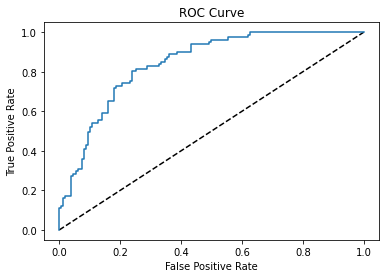

In [13]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)


# Plot ROC curve

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [14]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
roc_auc_score(y_test, y_pred_prob)

0.8421399176954733

In [15]:
cv_scores = cross_val_score(logreg, X, y, cv=5,scoring='roc_auc')
print(np.mean(cv_scores))

0.8326946191474492


#### 4.	What is outlier detection? Why is it useful? What methods can you use for outlier detection?

Outliers are observations in a dataset that don’t fit in some way.

The presence of outliers in a classification or regression dataset can result in a poor fit and lower predictive modeling performance.

Identifying and removing outliers is challenging with simple statistical methods for most machine learning datasets given the large number of input variables.

Simple statistical methods for identifying outliers can be methods that use standard deviations or the interquartile range. As visualised through a boxplot.

###### Automatic Outlier Detection
SCikit learn provides some methods of automatic outlier detection. Each method follows a different approach. Some of which are discussed below - 

Isolation Forest:
    
    It is based on modeling the normal data in such a way as to isolate anomalies that are both few in number and different in the feature space.
    The scikit-learn library provides an implementation of Isolation Forest in the IsolationForest class.
    
Minimum Covariance Determinant:
    
    This approach can be generalized by defining a hypersphere (ellipsoid) that covers the normal data, and data that falls outside this shape is considered an outlier. An efficient implementation of this technique for multivariate data is known as the Minimum Covariance Determinant, or MCD for short.
    The scikit-learn library provides access to this method via the EllipticEnvelope class.

Local Outlier Factor:
    
    The local outlier factor, or LOF for short, is a technique that attempts to harness the idea of nearest neighbors for outlier detection. Each example is assigned a scoring of how isolated or how likely it is to be outliers based on the size of its local neighborhood. Those examples with the largest score are more likely to be outliers.
    This can work well for feature spaces with low dimensionality (few features), although it can become less reliable as the number of features is increased
    The scikit-learn library provides an implementation of this approach in the LocalOutlierFactor class
    
One-Class SVM:
    
    The support vector machine, or SVM, algorithm developed initially for binary classification can be used for one-class classification.When modeling one class, the algorithm captures the density of the majority class and classifies examples on the extremes of the density function as outliers. This modification of SVM is referred to as One-Class SVM.
    The scikit-learn library provides an implementation of one-class SVM in the OneClassSVM class.

#### 5.	Perform a linear SVM to predict credit approval (last column) using this dataset: 
https://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29 . Make sure you look at the accompanying document that describes the data in the dat file. You will need to either convert this data to another file type or import the dat file to python. 

You can use this code, but otherwise you follow standard practices we have already used many times: 

from sklearn.svm import SVC

classifier = SVC(kernel='linear')

In [67]:
aca_df = pd.read_csv("../Datasets/ACA/australian.dat", sep="\s+",header=None)
aca_df.columns = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15']

In [68]:
display(aca_df.shape)
aca_df.head()

(690, 15)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [69]:
X = aca_df.drop('A15',axis=1)
y = aca_df['A15']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 25)

from sklearn.svm import SVC

classifier = SVC(kernel='linear')

classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

In [70]:
classifier.score(X_test,y_test)

0.8115942028985508

#### 6.	How did the SVM model perform? 

In [71]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       112
           1       0.80      0.79      0.79        95

    accuracy                           0.81       207
   macro avg       0.81      0.81      0.81       207
weighted avg       0.81      0.81      0.81       207



*The SVM model helped us increase the Class 1 recall score significantly which is the most import metric for diabetes dataset*

#### 7.	What kinds of jobs in data are you most interested in? Do some research on what is out there. Write about your thoughts in under 400 words.

*Having worked so far as a data engineer in the space of Data storage, backup and other data infrastructure admin roles. 
I now want to dig deeper and make sense of the data for which I was only responsible to manage so far.
My interest is in trandforming data into information and hence looking to work as Data Scientist. I believe my knowledge and understanding of how data is stored, managed and accessed would be very handy to kick start this journey of learning to transform data into meanigful report visually and numerically.*

#### DataCamp's Linear Classifiers in Python

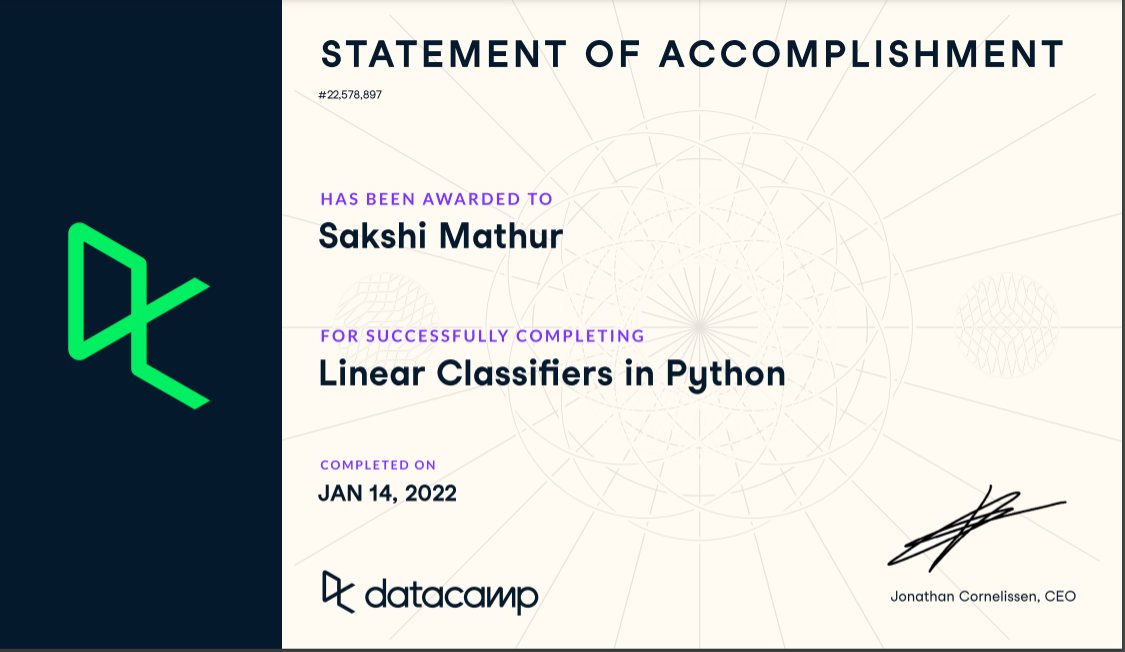

#### DataCamp's Python Data Science Toolkit Part 2 

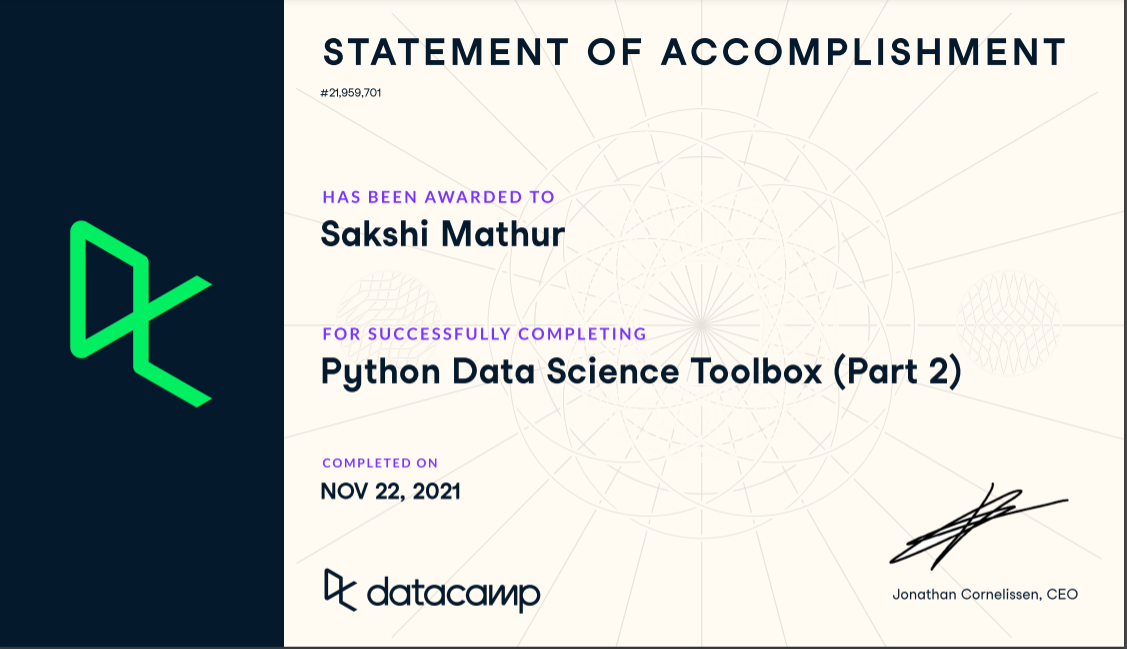